In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [16]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [18]:
# Define the data directory
data_dir = '../../dataset'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets

In [19]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 247, 'val': 112}


['crease', 'damage', 'dot', 'scratch']

In [20]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [25]:
import matplotlib.pyplot as plt

num_epochs = 35
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 0.5926 Acc: 0.8097
val Loss: 0.2756 Acc: 0.8839
train Loss: 0.5504 Acc: 0.8057
val Loss: 0.3069 Acc: 0.8750
train Loss: 0.6232 Acc: 0.7368
val Loss: 0.3118 Acc: 0.8929
train Loss: 0.8206 Acc: 0.6964
val Loss: 0.5832 Acc: 0.7946
train Loss: 0.7375 Acc: 0.7409
val Loss: 0.3665 Acc: 0.8571
train Loss: 0.6196 Acc: 0.7652
val Loss: 0.4699 Acc: 0.8125
train Loss: 0.7708 Acc: 0.7206
val Loss: 0.9109 Acc: 0.7232
train Loss: 0.8436 Acc: 0.6964
val Loss: 0.3757 Acc: 0.8125
train Loss: 0.6294 Acc: 0.7611
val Loss: 0.3439 Acc: 0.8929
train Loss: 0.5932 Acc: 0.7652
val Loss: 0.3504 Acc: 0.8839
train Loss: 0.7092 Acc: 0.7530
val Loss: 0.4497 Acc: 0.8482
train Loss: 0.6003 Acc: 0.7652
val Loss: 0.3379 Acc: 0.9107
train Loss: 0.5431 Acc: 0.7814
val Loss: 0.2694 Acc: 0.9018
train Loss: 0.7357 Acc: 0.7449
val Loss: 0.2898 Acc: 0.8661
train Loss: 0.7005 Acc: 0.7530
val Loss: 0.3301 Acc: 0.8125
train Loss: 0.6256 Acc: 0.7530
val Loss: 0.3627 Acc: 0.8304
train Loss: 0.6509 Acc: 0.7611
val Loss:

In [27]:

# Save the model
torch.save(model.state_dict(), 'resnet.pth')


In [26]:
print(f"Train losses length: {len(train_losses)}")
print(f"Validation losses length: {len(val_losses)}")
print(f"Train accuracies length: {len(train_accuracies)}")
print(f"Validation accuracies length: {len(val_accuracies)}")


Train losses length: 35
Validation losses length: 35
Train accuracies length: 35
Validation accuracies length: 35


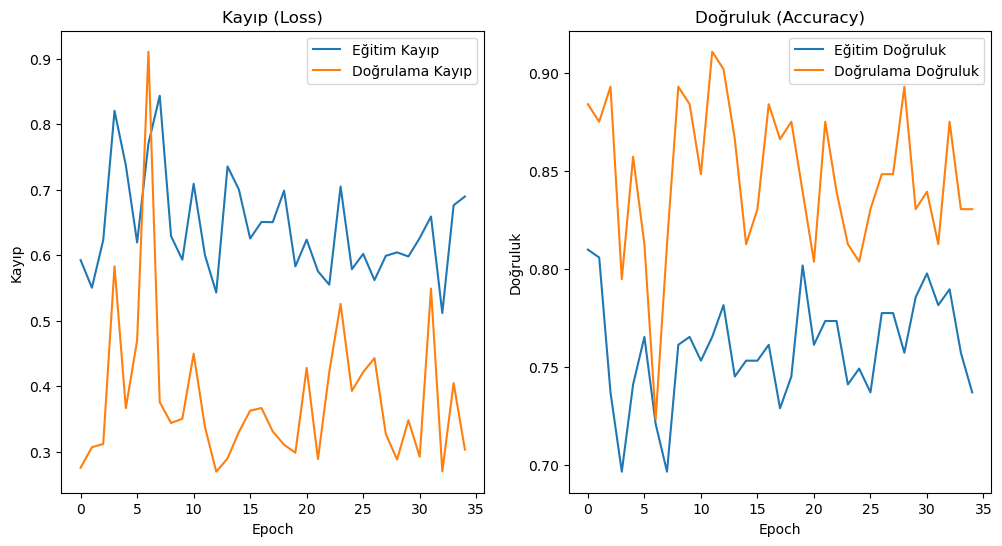

In [28]:
plt.figure(figsize=(12, 6))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Eğitim Kayıp')
plt.plot(range(num_epochs), val_losses, label='Doğrulama Kayıp')
plt.title('Kayıp (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Eğitim Doğruluk')
plt.plot(range(num_epochs), val_accuracies, label='Doğrulama Doğruluk')
plt.title('Doğruluk (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()

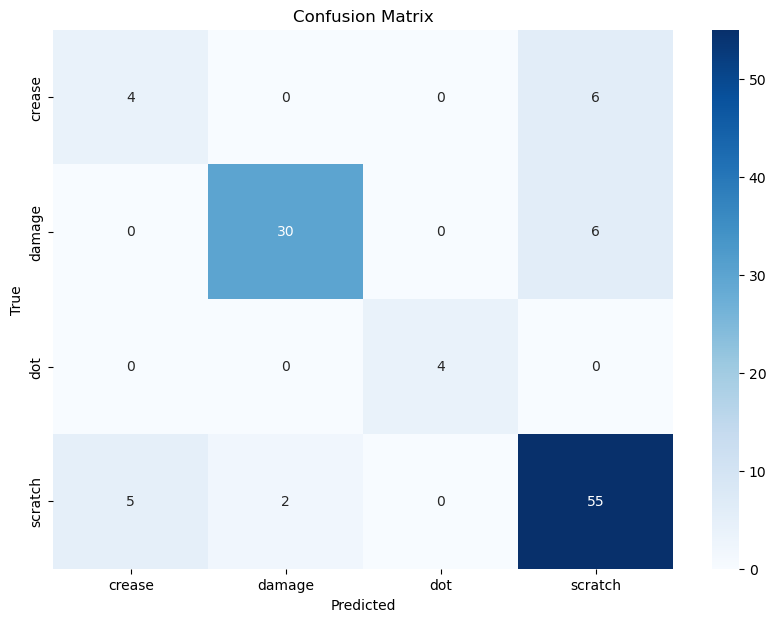

In [33]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

all_preds = []
all_labels = []

# Evaluate model on validation set to get predictions and labels
model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[i for i in range(len(class_names))])

# Plot confusion matrix
plot_confusion_matrix(cm, classes=class_names)

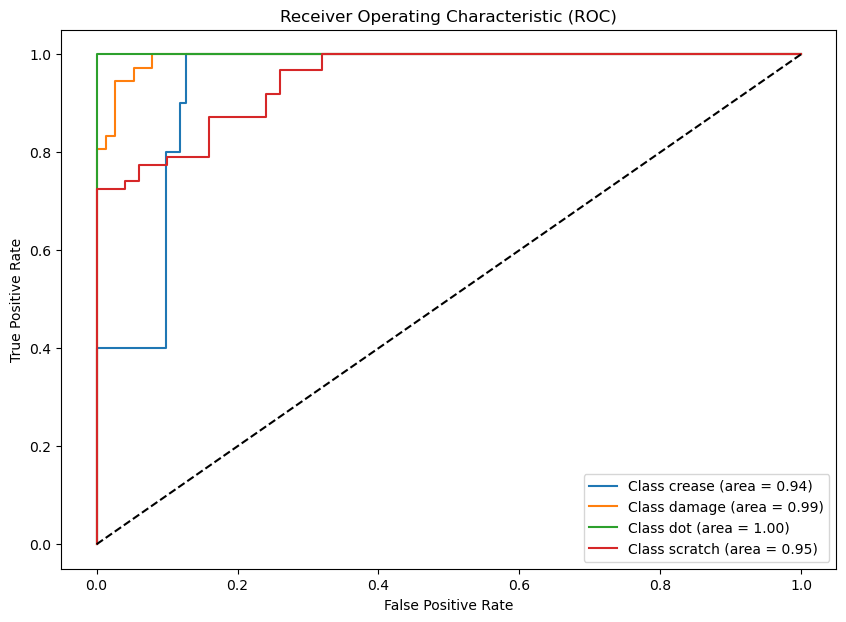

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Modeli değerlendirin ve tahminleri ve etiketleri toplayın
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)  # Olasılıkları al
        all_preds.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Binarize the labels for multi-class ROC
all_labels_bin = label_binarize(all_labels, classes=range(len(class_names)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

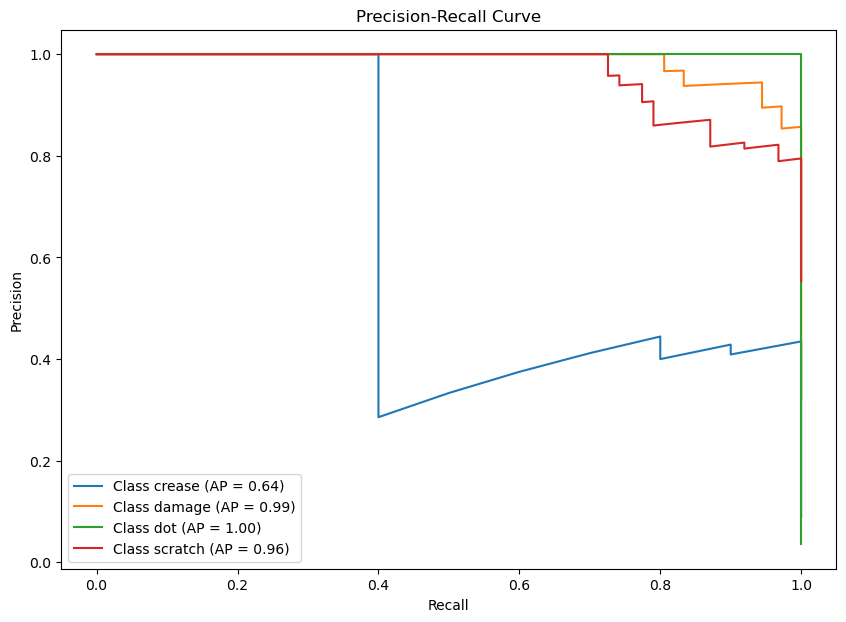

In [35]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision = {}
recall = {}
pr_auc = {}

for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_bin[:, i], all_preds[:, i])
    pr_auc[i] = average_precision_score(all_labels_bin[:, i], all_preds[:, i])

# Plot PR curves
plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    plt.plot(recall[i], precision[i], label=f'Class {class_names[i]} (AP = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [38]:
def top_n_accuracy(predictions, labels, n):
    top_n_correct = 0
    total = len(labels)
    
    for i in range(total):
        top_n_preds = np.argsort(predictions[i])[-n:]
        if labels[i] in top_n_preds:
            top_n_correct += 1
    
    return top_n_correct / total

top_1_accuracy = top_n_accuracy(all_preds, all_labels, 1)
top_5_accuracy = top_n_accuracy(all_preds, all_labels, 5)  # Örnek olarak

print(f"Top-1 Accuracy: {top_1_accuracy:.2f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.2f}")

Top-1 Accuracy: 0.83
Top-5 Accuracy: 1.00


# Classification on Unseen Image

To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference. 

In [5]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('resnet.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]




C:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2400\394956563.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECUR

Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

In [7]:
# Load and preprocess the unseen image
image_path = '../../Aero-engine_defect-detect_new/images/train/10.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


Perform inference using the model:

In [8]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['crease', 'damage', 'dot', 'scratch']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


The predicted class is: damage


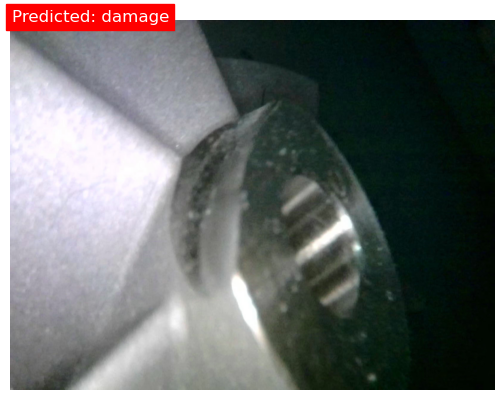

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

In [10]:
from torchvision import transforms
from PIL import Image

# Görüntüyü yükle ve ön işlemler yap
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = Image.open('../../Aero-engine_defect-detect_new/images/train/10.jpg')
image_tensor = preprocess(image).unsqueeze(0)  # Batch boyutunu ekle

In [11]:
# Tahmin yap
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)

print(predicted.item())  # Tahmin edilen sınıf


1


NameError: name 'num_epochs' is not defined